# Continuous-Time HMMs
This notebook gives the basic use of the CTHMM python library, a tool for working with continuous-time hidden markov models (CTHMMs).

This tutorial is broken into several sections:
1. Constructing a multinomial CTHMM with known parameters and simulating data
2. Fitting a CTHMM to observations
3. Decoding observations using a CTHMM
4. Interpolating the state at times where we have no observations

CTHMMs are a generalization of [hidden markov models](https://en.wikipedia.org/wiki/Hidden_Markov_model) to the case where 1) time varies contnuously, rather than proceeding in discrete steps, and 2) observations come at irregular intervals.  This shows up, for example, in medical contexts where patients' data is only taken when they see a doctor.

In [2]:
import os
os.getcwd()

'C:\\Users\\field\\OneDrive\\Desktop\\cthmm'

In [3]:
import numpy as np
from scipy.linalg import fractional_matrix_power, expm
import pandas as pd
from matplotlib import pyplot as plt
import cthmm

C:\Users\field\OneDrive\Desktop\cthmm\cthmm\cthmm.py:51: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(self.startprob)==self.n_states, 'Len of startprob must equal # states')
C:\Users\field\OneDrive\Desktop\cthmm\cthmm\cthmm.py:52: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(len(self.endprob)==self.n_states, 'Len of endprob must equal # states')


In [4]:
# Helper functions

def get_state_mapper(seq1, seq2):
    # Get mapping from states in seq1 --> state in seq2
    # Assume most common state in seq1 is same state as in seq2, etc
    state_mapper = dict(zip(
        pd.Series(seq1).value_counts().index,
        pd.Series(seq2).value_counts().index
    ))
    return state_mapper

# 1. Constructing a CT-HMM with known params and simulating data
We will learn about the following methods:
* MultinomialHMM(): the constructor
* MultinomialHMM.simulate(): lets us simulate data

Gotchas:
* Time is numerical-valued, so you get to choose the units
* A fitted CTHMM does NOT have any notion of how often observations are made.  To simulate data you must pass in a sample_dt() function that generates the random time lags between observations

In [6]:
# Define parameters for a simple CT-HMM and simulate three sequences of data, two for training and one for testing

# This gives the approx timescale for how long the system will remain in a given state.
holding_time_guess = 20.0

N_STATES = 3
Q = (1.0/holding_time_guess) * np.array([
    [-1.5, 1, 0.5],
    [0.3, -1, 0.7],
    [0.3, 0.2, -0.5]
])
emission_probs = np.array([
    [0.6, 0.2, 0.2],
    [0.2, 0.6, 0.2],
    [0.2, 0.2, 0.6]
])
start_probs = np.array([0.6, 0.2, 0.2])

real_hmm = cthmm.MultinomialCTHMM(n_states=N_STATES, Q=Q, emission_probs=emission_probs, startprob=start_probs)

sample_dt = np.random.random  # time between observations is Uniform[0,1]
#sample_dt = np.random.lognormal  # time between observations is heavy-tailed LogNormal

# Create three DataFrames of simulated data
df1 = real_hmm.simulate(n=1000, seed=1, sample_dt=sample_dt)
df2 = real_hmm.simulate(n=1000, seed=2, sample_dt=sample_dt)
df3 = real_hmm.simulate(n=1000, seed=3, sample_dt=sample_dt)

Rather than specifying the full Q matrix you can make life easier by just passing in the holding_time parameter when you construct the CTHMM.  In this case
* Every state will have an average holding time of holding_time
* All state transitions will be equally likely
Obviously this is hugely constrained.  On the other hand, in real situations often you don't have the data available to construct a really good Q matrix, but you *do* have a rough sense of how long the system typically stays in a given state.

In [7]:
cthmm_w_uniform_Q = cthmm.MultinomialCTHMM(n_states=3, emission_probs=emission_probs, holding_time=20.0)

# 2. Fitting a model to the data
The two main params that get fitted are the emission probabilities (in this case it's a multinomial HMM - we could have other models like Gaussians instead) and the matrix Q.  Generally the emission probabiities are comparatively easy to fit, and you can use the EM algorithm to fit them.  If you have good business knowledge about what Q should be then you can just do that.

If you want to fit Q as well then you can do that too, using the fit_model function.  Note that we strongly encourage using the default_Q(n_states) function as your starting guess, then dividing it by your best guesstimate of how long a particular state persists on average.

We will learn about:
* fit_multinomial_emission_probs(): uses Baum-Welch algo to fit multinomial emission probs
* default_Q(): gives a good starting guess for Q if you know the # states and have a ballpark guess of the average holding time
* fit_model(): fits Q and the emission probabilities

Gotchas:
* With normal HMMs a sequence of observation is something like a List[Observation], since the time of an observation is just its location in the list.  But we need to also include timestamps, and so we represent a sequence of data as a pair (List[Observation], List[Number]).  We could instead have used a List[Tuple(Observation,Number)], a Pandas sequence with its index, or something else along those lines.

In [8]:
# If we have business knowledge of the Q matrix, which is tricky to fit, it is possible to ONLY fit 
# the emission probs:
#imp.reload(cthmm)

foo_hmm = cthmm.MultinomialCTHMM(n_states=N_STATES, n_emissions=3, Q=Q, seed=1)
foo_hmm.fit_observation_params([(df1.emission, df1.time), (df2.emission, df2.time)], max_iter=10)
print('Final:\n', foo_hmm.emission_probs)
print('Correct:\n', emission_probs)

Starting emission_probs:
 [[0.38116185 0.18365921 0.43517895]
 [0.11277216 0.84958463 0.03764321]
 [0.4491129  0.21239428 0.33849282]]
Updated emission_probs.  time=6sec
 [[0.20502653 0.19126965 0.60370382]
 [0.18005397 0.59541423 0.22453181]
 [0.62205424 0.18488838 0.19305738]]
Final:
 [[0.20502653 0.19126965 0.60370382]
 [0.18005397 0.59541423 0.22453181]
 [0.62205424 0.18488838 0.19305738]]
Correct:
 [[0.6 0.2 0.2]
 [0.2 0.6 0.2]
 [0.2 0.2 0.6]]


In [9]:
# We assume you have business knowledge that 20 units of time is roughly the timescale of how long a state lasts.
holding_time_guess = 20.0

np.random.seed(4)
fitted_hmm = cthmm.MultinomialCTHMM(n_states=N_STATES, n_emissions=3, holding_time=holding_time_guess)
fitted_hmm.fit([(df1.emission, df1.time), (df2.emission, df2.time)], verbose=False, max_iter=10)

print('\nWARNING: in general the HMM may have renamed states, like mixing up 0 and 1.'
      '\n  Look out for that in comparing the fitted params to the actual ones')
print('\nActual Q:\n', Q)
print('Fitted Q:\n', fitted_hmm.Q)
print('\nActual emission probs:\n', emission_probs)
print('Fitted emission probs:\n', fitted_hmm.emission_probs)


  Look out for that in comparing the fitted params to the actual ones

Actual Q:
 [[-0.075  0.05   0.025]
 [ 0.015 -0.05   0.035]
 [ 0.015  0.01  -0.025]]
Fitted Q:
 [[-0.04475077  0.00841078  0.03633999]
 [ 0.03164192 -0.05540048  0.02375856]
 [ 0.00661282  0.01156588 -0.0181787 ]]

Actual emission probs:
 [[0.6 0.2 0.2]
 [0.2 0.6 0.2]
 [0.2 0.2 0.6]]
Fitted emission probs:
 [[0.17577014 0.60077973 0.22345013]
 [0.62671098 0.1896978  0.18359122]
 [0.20692448 0.19308045 0.59999507]]


# 3. Decoding Observations
The main use case of fitted HMMs is to take a sequence of observations and predict the underlying sequence of states that generated those observations.  There are two main algorithms for doing this (they are designed for normal HMMs, but they generalize easily to the continuous-time case) which usually give very similar results:

* The Viterbi algorithm finds the single sequence of states that maximizes the a posteriori likelihood Pr[states]Pr[observations|states].  This is the default algorithm here.

* The forward-backward algorithm computes the single best-guess state for every observation in the sequence.  This is often called the "MAP" guess (maximum a-posteriori).  The MAP guess can be different from the Viterbi algorithm if the best sequence has S1=sA, but several almost-as-good sequence have S1=sB.

A major difference between them in practice that the forward-backward algorithm gives you a table of how likely each state is at each point in time.

We will see:
* MultinomialCTHMM.predict(): Predicting by either Viterbi or Forward-backward
* MultinomialCTHMM.viterbi(): Viterbi algorithm
* MultinomialCTHMM.forward_backward(): forward-backward algorithm, which returns the sequence *and* table of probs
* MultinomialCTHMM.get_logprob(): gives the LogProb of a sequence of observations/states for a CT-HMM

In [10]:
# Compare accuracies of Viterbi vs FB w the fitted params, vs FB if we had perfect param knowledge

# Get predicted state sequences by viterbi or forward-backward algorithm
viterbi_seq_raw = fitted_hmm.predict(df3.emission, df3.time)  # default algorithm='viterbi'
fb_seq_raw = fitted_hmm.predict(df3.emission, df3.time, algorithm='forward-backward')

# Run on the training data to get mapping between original states and fitted states
seq1 = fitted_hmm.predict(df1.emission, df1.time)
mapper = get_state_mapper(seq1, df1.state)

# Correct for possibility that fitted_hmm gave underlying states different
# names than were used to simulate them, like swapping states 0 and 1
viterbi_seq = pd.Series(viterbi_seq_raw).apply(lambda s: mapper[s])
fb_seq = pd.Series(fb_seq_raw).apply(lambda s: mapper[s])

print('FB guesses right more often than Viterbi:')
print('  Viterbi accuracy:', (viterbi_seq==df3.state).mean())
print('  FB accuracy:', (fb_seq==df3.state).mean())

print('\nLogProbs for Viterbi and FB predictions. '
     'We see that even though FB is right more often, '
     '\nthe Viterbi seq has higher log-prob (this is to be expected).')
print('  Viterbi LogProb:', fitted_hmm.get_logprob(df3.emission, viterbi_seq, df3.time))
print('  FB LogProb:', fitted_hmm.get_logprob(df3.emission, fb_seq, df3.time))

FB guesses right more often than Viterbi:
  Viterbi accuracy: 0.966
  FB accuracy: 0.971

LogProbs for Viterbi and FB predictions. We see that even though FB is right more often, 
the Viterbi seq has higher log-prob (this is to be expected).
  Viterbi LogProb: -1163.4331153257099
  FB LogProb: -1166.1088800473137



When the FB alorithm IS wrong, its guesses were lower-confidence anyway


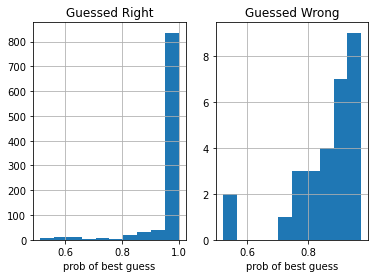

In [11]:
import importlib
importlib.reload(cthmm)
# If we call the predict_proba() method we can get back
# a matrix of all the a-posteriori probabilities.
# Under the hood it is generated by the forward-backward algorithm
fb_probs = fitted_hmm.predict_proba(df3.emission, df3.time)

print('\nWhen the FB alorithm IS wrong, its guesses were lower-confidence anyway')
max_probs = pd.Series(fb_probs.max(axis=1))
plt.subplot(121)
max_probs[df3.state==fb_seq].hist();plt.title('Guessed Right');plt.xlabel('prob of best guess')
plt.subplot(122)
max_probs[df3.state!=fb_seq].hist();plt.title('Guessed Wrong');plt.xlabel('prob of best guess')
plt.show()

In [12]:
# Compare to normal HMM

from hmmlearn import hmm

# Sometimes the results are bad enough you get the wrong state-state mapper.
# This seed has it find the right one
np.random.seed(4)

inp1 = df1.emission.to_numpy().reshape((len(df1.emission),1))
inp2 = df2.emission.to_numpy().reshape((len(df2.emission),1))
inp12 = np.stack([inp1, inp2], axis=1).reshape((len(inp1)+len(inp2), 1))

vanilla_hmm = hmm.MultinomialHMM(3)
vanilla_hmm.fit(inp12, [len(inp1), len(inp2)])

# Run on the training data to get mapping between original states and fitted states
seq1 = vanilla_hmm.predict(inp1)
mapper_vanilla = get_state_mapper(seq1, df1.state)

# Predict states of test data
inp = df3.emission.to_numpy().reshape((len(df3.emission),1))
seq_vanilla = vanilla_hmm.predict(inp)

print('To show the importance of accounting for irregular timestamps, '
      '\nhere is accuracy if we just pretended time steps are all equal:')
print('  Vanilla HMM Accuracy:', pd.Series(seq_vanilla).apply(lambda s: mapper_vanilla[s]).eq(df3.state).mean())

To show the importance of accounting for irregular timestamps, 
here is accuracy if we just pretended time steps are all equal:
  Vanilla HMM Accuracy: 0.564


# 4. Interpolating states at times with no observations
Unlike a discrete-time HMM, in a CTHMM the system has an underlying state at *all* points in time, not just when we make observations.  One of the most important jobs of a CT-HMM is to be able to guess the state of the system at times in between observations.  You can do that with the interpolate() function, which takes in a sequence of observations, the times they were made, and then the times K at which you wish to interpolate.  It will return a K x n_states array giving the probabilities of each state at each time.

In [13]:
print('Notice the state change at time=301')
df1[600:604]

Notice the state change at time=301


,time,state,emission
600,300.326617,2,1
601,300.660227,2,2
602,301.560567,0,0
603,301.796089,0,1


In [14]:
mn, mx = df1.time.min(), df1.time.max()
times_to_interp = [
    mn-100, # way before 1st obs
    300.5, # right before state change
    301.6, # right after state change
    mx+100 # way after last obs
]
print('Notice that:'
      '\n* Way before/after the data the predictions are almost identical'
      '\n  since the system is near its stationary distribution.'
      '\n* The interpolation catches the state change at time=301 (though the'
      '\n  CTHMM swapped which state is 0 and which is 1)'
     )
print('Stationary distribution:\n', fitted_hmm.get_stationary_distribution())
print('Interpolated states:\n', fitted_hmm.interpolate(df1.emission, df1.time, times_to_interp))

Notice that:
* Way before/after the data the predictions are almost identical
  since the system is near its stationary distribution.
* The interpolation catches the state change at time=301 (though the
  CTHMM swapped which state is 0 and which is 1)
Stationary distribution:
 [0.20812814 0.16290594 0.62896592]
Interpolated states:
 [[0.2124623  0.16332366 0.62421404]
 [0.01198385 0.26919321 0.72241716]
 [0.00684639 0.75555538 0.23693166]
 [0.20808816 0.16270295 0.62920888]]
